# Global constants

In [133]:
GRAIN_TYPE = 'WheatAdded_Type'
#GRAIN_TYPE = 'newWheatData'
#GRAIN_TYPE = 'CornAdded_Type'
#GRAIN_TYPE = 'cleaned_data'
# GRAIN_TYPE = 'Oats'

# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
# GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + '_t2_kcv_dnn_mc.h5'

In [134]:
#Import libraries
import requests
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.4.1


In [135]:
print(tf.config.list_physical_devices('GPU'))
# print(tf.version.VERSION)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Helper functions

In [136]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(x=predictions, y=trueValues)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

In [137]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)
#df = df[df['Variety'] == 'SOUTH DAKOTA']
#df = df[(df['Density'] >= 0.72) & (df['Density'] <= 0.88)]

print("From USDA: ", URL)


df.head()

From USDA:  ../Datasets/processed/WheatAdded_Type.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
0,0,KANSAS,7.0,8.9,11.3,0.7356,8.8258,-55.973,-415.973,2.416,0.243,15.855506,-6.341975,62.3,61.7806
1,1,KANSAS,8.0,8.9,11.3,0.7356,10.2572,-114.289,-474.289,2.412,0.246,15.855506,-11.142320,71.2,82.0576
2,2,KANSAS,9.0,8.9,11.3,0.7356,11.5679,-168.171,-528.171,2.395,0.246,15.855506,-14.537729,80.1,104.1111
3,3,KANSAS,10.0,8.9,11.3,0.7356,12.8795,134.849,-585.151,2.390,0.246,15.855506,10.470049,89.0,128.7950
4,4,KANSAS,11.0,8.9,11.3,0.7356,13.7649,83.502,-636.498,2.371,0.238,15.855506,6.066299,97.9,151.4139


# 2. Overview of data


In [138]:
# Data summary
df.describe()

,Unnamed: 0,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,402.500000,10.811414,7.088834,16.189541,0.796298,18.410033,-4.604663,-633.488065,2.912112,0.499187,16.189541,-0.377074,77.159677,215.799030
std,232.816451,3.530055,1.554604,3.794772,0.067384,5.946835,101.951444,219.510760,0.305758,0.186739,0.629743,6.071761,32.552200,124.108325
min,0.000000,5.000000,4.400000,10.260000,0.625400,8.002300,-179.335000,-1274.435000,2.340000,0.220000,15.352809,-17.418676,22.000000,40.011500
25%,201.250000,8.000000,6.500000,13.680000,0.745400,13.524700,-88.842000,-793.405750,2.688500,0.337000,15.855506,-5.077754,52.800000,107.817375
50%,402.500000,11.000000,7.700000,16.225000,0.801300,18.131600,-9.838500,-602.380500,2.861500,0.470500,16.400366,-0.589378,71.200000,195.600450
75%,603.750000,13.000000,7.700000,18.810000,0.842000,23.098000,80.957250,-456.055750,3.109750,0.639000,16.401988,4.300734,100.100000,310.863000
max,805.000000,18.000000,8.900000,24.410000,0.927800,29.897000,179.048000,-235.044000,4.038000,0.987000,17.344167,14.827701,160.200000,538.146000


In [139]:
# Dimension of the dataset
df.shape

(806, 15)

In [140]:
# Check info about missing values in dataframe
df.isnull().sum()

Unnamed: 0                0
Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
Type                      0
Phase/Attn                0
Freq*d(cm)                0
Freq*Attn                 0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [141]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                   # 'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    'Type',
                    ]]

df_targets = df[['M%']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [142]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize the entire dataset (input features)
dataset_x_norm = scaler_input.fit_transform(dataset_x)  # Use transform, NOT fit_transform

# Normalize the entire dataset (output targets)
dataset_y_norm = scaler_output.fit_transform(dataset_y)  # Use transform, NOT fit_transform


## Normalize datasets

In [143]:
# Perform train-test split on RAW DATA
X_train, X_test, y_train, y_test = train_test_split(dataset_x_norm, dataset_y_norm, 
                                                    test_size=0.15
                                                    ,random_state=42
                                                    )

SyntaxError: invalid syntax (1727062809.py, line 1)

# K-cross Validation
* Input features: 7
* Output targets: 2


## Defining model

In [ ]:
from keras import layers, Sequential, regularizers

# Define the model-building function
def my_model():
  my_model = Sequential([
    
    layers.Dense(109, input_shape=(6,), activation='relu',),
    layers.Dense(109, activation='relu', ),
    layers.Dense(109, activation='relu',),
    layers.Dense(1, activation='linear')  # Output layer with 2 neurons for the two regression targets
  ])

  opt = tf.keras.optimizers.Adam(learning_rate=0.00091) # 0.0006 
  my_model.compile(
      optimizer = opt,
      loss = 'mse',
      metrics = ['accuracy']
  )

  return my_model

plot_model(my_model(), show_shapes=True, show_layer_names=True)
my_model().summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_248 (Dense)            (None, 109)               763       
_________________________________________________________________
dense_249 (Dense)            (None, 109)               11990     
_________________________________________________________________
dense_250 (Dense)            (None, 109)               11990     
_________________________________________________________________
dense_251 (Dense)            (None, 1)                 110       
Total params: 24,853
Trainable params: 24,853
Non-trainable params: 0
_________________________________________________________________


## Running model with KCV

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.callbacks import Callback
class MaxAbsErrorCallback(Callback):
    def __init__(self):  
        self.max_abs_errors = np.zeros((K_FOLD_SPLITS, NUM_EPOCHS))  # Initialize array

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(X_test) 
        y_pred = scaler_output.inverse_transform(y_pred) 
        y_true = scaler_output.inverse_transform(y_test) 

        abs_errors = np.abs(y_true[:, 0] - y_pred[:, 0])
        max_abs_error = np.max(abs_errors)

        # Store errors in the pre-allocated Array
        fold_index = cv.get_n_splits() - 1  # Get the current fold index
        self.max_abs_errors[fold_index, epoch] = max_abs_error 
        print(f"Epoch {epoch + 1}: Max Absolute Error = {max_abs_error:.4f}") 

    def on_train_end(self, logs={}):  
        epoch_averages = np.mean(self.max_abs_errors, axis=0)  # Average across folds
        print(min(epoch_averages))
        for epoch_idx, avg_error in enumerate(epoch_averages):
            print(f"Epoch {epoch_idx + 1} Average Max Abs Error: {avg_error:.4f}")

NUM_EPOCHS = 185# 180
BATCH_SIZE = 10
K_FOLD_SPLITS = 10


# Define the cross-validation process to be used inside cross_val_Score evaluation
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y = y_train[:,0]

X = X_train

i = 0
arr_loss = list()
min_loss = 1000000
best_model = None
history = None
history_best_model = None


# Perform k-fold cross-validation
for train_indices, test_indices in cv.split(X_train):
  print('####################### Iteration  ', i, ' #######################')
  trainX, testX = np.array(X[train_indices]), np.array(X[test_indices])
  trainY = (Y[train_indices])
  testY = (Y[test_indices])

  model = my_model()
  history = model.fit(trainX, trainY,
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data = (testX, testY),
            callbacks=[MaxAbsErrorCallback()]  # Add the callback
  )


  #testing on validation set process
  loss, rmse = model.evaluate(x = testX, y = testY, verbose=1)
  
  print(f"Loss = {loss}, rmse = {rmse}" )

  if loss < min_loss:
    best_model = model
    history_best_model = history
    min_loss = loss

  arr_loss.append(loss)
  print('Loss array: ', arr_loss)
  i+=1

# Saving the best model within the k folds
best_model.save('Best models/target_2/single_models/density_kfold_dnn_single')

####################### Iteration   0  #######################
Epoch 1/180
62/62 [==============================] - 0s 1ms/step - loss: 0.0684 - accuracy: 0.0635 - val_loss: 0.0042 - val_accuracy: 0.1159
Epoch 1: Max Absolute Error = 2.2539
Epoch 2/180
62/62 [==============================] - 0s 892us/step - loss: 0.0032 - accuracy: 0.0876 - val_loss: 0.0029 - val_accuracy: 0.1159
Epoch 2: Max Absolute Error = 2.0038
Epoch 3/180
62/62 [==============================] - 0s 789us/step - loss: 0.0021 - accuracy: 0.0748 - val_loss: 0.0031 - val_accuracy: 0.1159
Epoch 3: Max Absolute Error = 2.4645
Epoch 4/180
62/62 [==============================] - 0s 742us/step - loss: 0.0018 - accuracy: 0.0895 - val_loss: 0.0016 - val_accuracy: 0.1159
Epoch 4: Max Absolute Error = 1.8252
Epoch 5/180
62/62 [==============================] - 0s 802us/step - loss: 0.0017 - accuracy: 0.0830 - val_loss: 0.0014 - val_accuracy: 0.1159
Epoch 5: Max Absolute Error = 1.6507
Epoch 6/180
62/62 [====================

62/62 [==============================] - 0s 717us/step - loss: 1.4892e-04 - accuracy: 0.0791 - val_loss: 2.3568e-04 - val_accuracy: 0.1159
Epoch 52: Max Absolute Error = 0.9849
Epoch 53/180
62/62 [==============================] - 0s 1ms/step - loss: 1.5030e-04 - accuracy: 0.0717 - val_loss: 1.3060e-04 - val_accuracy: 0.1159
Epoch 53: Max Absolute Error = 0.7852
Epoch 54/180
62/62 [==============================] - 0s 764us/step - loss: 1.3365e-04 - accuracy: 0.0812 - val_loss: 4.4781e-04 - val_accuracy: 0.1159
Epoch 54: Max Absolute Error = 1.4206
Epoch 55/180
62/62 [==============================] - 0s 899us/step - loss: 1.9819e-04 - accuracy: 0.0767 - val_loss: 2.5524e-04 - val_accuracy: 0.1159
Epoch 55: Max Absolute Error = 1.1123
Epoch 56/180
62/62 [==============================] - 0s 877us/step - loss: 1.6762e-04 - accuracy: 0.0911 - val_loss: 1.6582e-04 - val_accuracy: 0.1159
Epoch 56: Max Absolute Error = 1.0384
Epoch 57/180
62/62 [==============================] - 0s 824us/st

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


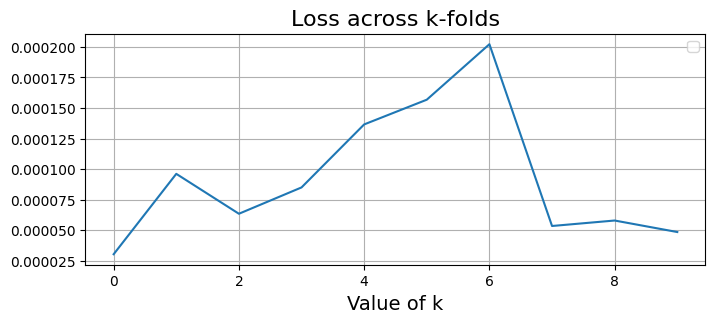

In [ ]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

### Loss curves

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


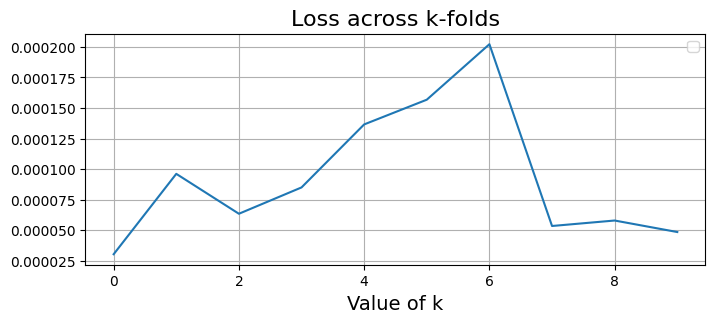

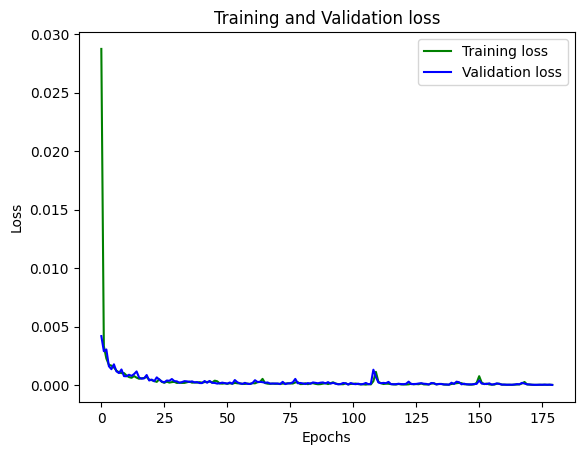

In [ ]:
def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()



# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

# Training and Validation Loss
plot_loss_curve(history_best_model, NUM_EPOCHS)

# Prediction on Test Dataset

Elapsed time: 0.0143 seconds
Maxval here is:  24.917233


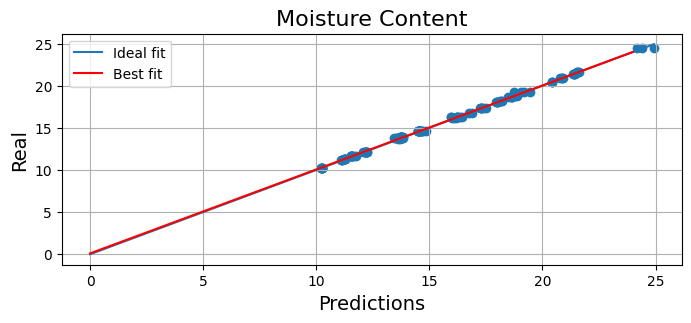

In [ ]:
import time

start_time = time.time()
Y_pred_normalized = best_model.predict(X_test)
end_time = time.time()
Y_pred_normalized_entire = best_model.predict(dataset_x_norm)
# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")


Y_pred = scaler_output.inverse_transform(Y_pred_normalized)
Y_pred_entire = scaler_output.inverse_transform(Y_pred_normalized_entire)
Y_actual = scaler_output.inverse_transform(y_test)
Y_actual_entire = np.array(df_targets)
# Moisture Content
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")
a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0])), 1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_MC.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [ ]:
from sklearn.metrics import r2_score

# MOISTURE CONTENT
#   - R-squared
# mc_r2_score = r2_score(Y_actual[:, 0], Y_pred[:, 0])
mc_r2_score = calculate_r_squared(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("{:#.4g}".format(mc_r2_score))




0.9991


### RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
from sigfig import round

#MC
rmse_mc = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
print('RMSE_MC: ', "{0:.4g}".format(rmse_mc))

RMSE_MC:  0.1171


Now we will compare with the results from Trabelsi's paper. This is single moisture prediction 

R^2 : 0.993\
Mean Squared Error: 0.028\
Mean absolute Error: 0.135\
Min. Absolute Error: 0.004\
Max Absolute Error: 0.441

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error, r2_score
from sigfig import round

mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,0])):
    sum = Y_actual[:,0][i] - Y_pred[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))




R^2: 0.9990
Mean Squared Error:  0.0137
Mean Absolute Error:  0.0799
Min Absolute Error:  0.0006882476806637783
Max Absolute Error:  0.5072325134277342


In [ ]:
mc_r2_score = r2_score(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual_entire[:,0])):
    sum = Y_actual_entire[:,0][i] - Y_pred_entire[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

R^2: 0.9995
Mean Squared Error:  0.006579
Mean Absolute Error:  0.05931
Min Absolute Error:  4.058837890497102e-05
Max Absolute Error:  0.5072325134277342
